In [1]:
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip && unzip v2_Annotations_Train_mscoco && \
wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip && unzip v2_Questions_Train_mscoco

--2024-04-08 11:27:07--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.61.0, 54.231.172.24, 52.216.146.61, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.61.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21708861 (21M) [application/zip]
Saving to: ‘v2_Annotations_Train_mscoco.zip’

v2_Annotations_Trai 100%[===================>]  20.70M  53.3MB/s    in 0.4s    

2024-04-08 11:27:07 (53.3 MB/s) - ‘v2_Annotations_Train_mscoco.zip’ saved [21708861/21708861]

Archive:  v2_Annotations_Train_mscoco.zip
  inflating: v2_mscoco_train2014_annotations.json  
--2024-04-08 11:27:12--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.161.104, 52.216.60.136, 52.217.202.176, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.161.104|:443... connected.
HTTP request sent, awaiting res

In [2]:
!ls

sample_data			      v2_OpenEnded_mscoco_train2014_questions.json
v2_Annotations_Train_mscoco.zip       v2_Questions_Train_mscoco.zip
v2_mscoco_train2014_annotations.json


In [3]:
!pip install transformers

In [4]:
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import json
import copy
import glob
import torch
import random
import operator
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from google.colab import files
from numpy.random import choice
from sklearn.manifold import TSNE
from collections import Counter, defaultdict
import pandas as pd
import csv
from torch.utils.data import Dataset
from torchvision.transforms import *
from tqdm.notebook import tqdm
import pickle
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertForSequenceClassification
import cv2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.models as models

In [5]:
annotations = json.load(open("v2_mscoco_train2014_annotations.json"))
questions = json.load(open("v2_OpenEnded_mscoco_train2014_questions.json"))

In [5]:
annotations.keys()

dict_keys(['info', 'license', 'data_subtype', 'annotations', 'data_type'])

In [39]:
print(f"annotations['info']: \n {annotations['info']}\n")
print(f"annotations['license']: \n {annotations['license']}\n")
print(f"annotations['data_type']: \n {annotations['data_type']}\n")
print(f"annotations['data_subtype']: \n {annotations['data_subtype']}\n")
print(f"annotations['annotations'][:5]: \n {annotations['annotations'][:5]}\n")

annotations['info']: 
 {'description': 'This is v2.0 of the VQA dataset.', 'url': 'http://visualqa.org', 'version': '2.0', 'year': 2017, 'contributor': 'VQA Team', 'date_created': '2017-04-26 17:07:13'}

annotations['license']: 
 {'url': 'http://creativecommons.org/licenses/by/4.0/', 'name': 'Creative Commons Attribution 4.0 International License'}

annotations['data_type']: 
 mscoco

annotations['data_subtype']: 
 train2014

annotations['annotations'][:5]: 
 [{'question_type': 'what is this', 'multiple_choice_answer': 'net', 'answers': [{'answer': 'net', 'answer_confidence': 'maybe', 'answer_id': 1}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'netting', 'answer_confidence': 'yes', 'answer_id': 4}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 6}, {'answer': 'mesh', 'answer_confidence': 'maybe', 'answer_id': 7}, {'answ

In [6]:
annotations['annotations'][0]

{'question_type': 'what is this',
 'multiple_choice_answer': 'net',
 'answers': [{'answer': 'net', 'answer_confidence': 'maybe', 'answer_id': 1},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'netting', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'mesh', 'answer_confidence': 'maybe', 'answer_id': 7},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 458752,
 'answer_type': 'other',
 'question_id': 458752000}

In [7]:
questions.keys()

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])

In [36]:
print(f"questions['info']: \n {questions['info']}\n")
print(f"questions['task_type']: \n {questions['task_type']}\n")
print(f"questions['data_type']: \n {questions['data_type']}\n")
print(f"questions['license']: \n {questions['license']}\n")
print(f"questions['data_subtype']: \n {questions['data_subtype']}\n")

questions['info']: 
 {'description': 'This is v2.0 of the VQA dataset.', 'url': 'http://visualqa.org', 'version': '2.0', 'year': 2017, 'contributor': 'VQA Team', 'date_created': '2017-04-26 17:07:13'}

questions['task_type']: 
 Open-Ended

questions['data_type']: 
 mscoco

questions['license']: 
 {'url': 'http://creativecommons.org/licenses/by/4.0/', 'name': 'Creative Commons Attribution 4.0 International License'}

questions['data_subtype']: 
 train2014



In [40]:
questions['questions'][:5]

[{'image_id': 458752,
  'question': 'What is this photo taken looking through?',
  'question_id': 458752000},
 {'image_id': 458752,
  'question': 'What position is this man playing?',
  'question_id': 458752001},
 {'image_id': 458752,
  'question': 'What color is the players shirt?',
  'question_id': 458752002},
 {'image_id': 458752,
  'question': 'Is this man a professional baseball player?',
  'question_id': 458752003},
 {'image_id': 262146,
  'question': 'What color is the snow?',
  'question_id': 262146000}]

In [6]:
questionid2question = {item['question_id']: item['question'] for item in questions['questions']}

In [41]:
# questionid2question
for key in random.sample( list( questionid2question.keys() ) , 5 ):
    print(f"{key}: {questionid2question[key]}")

342363020: What nationality is this cuisine?
178933001: Does his tie and shirt match?
390658002: What time is on the clocks?
347638000: How many people are in the water?
396835011: What is this man pulling with his truck?


In [53]:
# annotations['annotations'][0]
# Find the element with question_id == 342363020
random_question_id = random.sample( list( questionid2question.keys() ) , 1 )[0]
element_with_question_id_2 = next((annotation for annotation in annotations['annotations'] if annotation['question_id'] == random_question_id), None)


print(f"question_id:{random_question_id} , question:{questionid2question[random_question_id]}\n")
print(f"annotations['annotations'][{random_question_id}]")
element_with_question_id_2


question_id:579758011 , question:What is the man preparing to do in the baseball uniform?

annotations['annotations'][579758011]


{'answer_type': 'other',
 'multiple_choice_answer': 'throw ball',
 'answers': [{'answer': 'throw', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'throw ball', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'throw ball', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'pitch', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'throw ball', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'throw', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'pitch', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'throw baseball', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'pitch', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'throw ball', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 579758,
 'question_type': 'what is the man',
 'question_id': 579758011}

In [7]:
def get_most_probable_answers(answers):
    answers_count = dict()
    for answer in answers:
        answers_count[answer['answer']] = answers_count.get(answer['answer'], 0) + 1
    max_answer = max(answers_count, key = answers_count.get)
    return max_answer

In [8]:
def build_dataset(questions, annotations):
    questionid2question = {item['question_id']: item['question'] for item in questions['questions']}
    questions = questions['questions'] # image_id, question, question_id
    annotations = annotations['annotations'] # image_id, question_id, answers
    question = [questionid2question[item['question_id']] for item in annotations]
    image_id = [item['image_id'] for item in annotations]
    answer = [get_most_probable_answers(item['answers']) for item in annotations]
    df = pd.DataFrame(list(zip(image_id, question, answer)), columns =['image_id', 'question', 'answer'])
    return df


In [9]:
df = build_dataset(questions, annotations)

In [57]:
df.head()

,image_id,question,answer
0,458752,What is this photo taken looking through?,net
1,458752,What position is this man playing?,pitcher
2,458752,What color is the players shirt?,orange
3,458752,Is this man a professional baseball player?,yes
4,262146,What color is the snow?,white


In [10]:
all_possible_answers = df['answer'].unique()
len(all_possible_answers)

22706

In [11]:
threshold_instance_per_class = 1000
threshold_num_classes = 20
sample_size = 1000

def choose_classes_strategy(filterd_answers_freq, threshold_num_classes=20, strategy='random'):
    strategy = strategy.lower()
    assert strategy in ['max', 'min', 'random', None]

    if strategy is None:
        # choose all classes
        chosen_classes = filterd_answers_freq.keys()
    elif strategy == 'min':
        # choose classes which have minimum number of frequencies
        assert(threshold_num_classes is not None)
        chosen_classes = sorted(filterd_answers_freq, key=lambda x:filterd_answers_freq[x])[0:threshold_num_classes]
    elif strategy == 'max':
        # choose classes which have maximum number of frequencies
        assert(threshold_num_classes is not None)
        chosen_classes = sorted(filterd_answers_freq, key=lambda x:filterd_answers_freq[x], reverse=True)[0:threshold_num_classes]
    elif strategy == 'random':
        # choose classes randomly
        assert(threshold_num_classes is not None)
        chosen_classes = random.sample(list(filterd_answers_freq.keys()), threshold_num_classes)

    return chosen_classes


def filter_dataframe(df, chosen_classes, sample_size=1000):
    sampled_rows = []
    # TODO 1: sampling from chosen classes
    for class_name in chosen_classes:
        class_df = df[df['answer'] == class_name]
        sampled_rows_from_class = class_df.sample(min(sample_size, len(class_df)), replace=True, random_state=42)
        sampled_rows.append(sampled_rows_from_class)

    return pd.concat(sampled_rows)



def get_final_df(df, threshold_instance_per_class=1000, threshold_num_classes=20, sample_size=1000):
    ans_freq = df['answer'].value_counts()
    filterd_answers_freq = ans_freq[ans_freq > threshold_instance_per_class]

    filterd_answers_freq = dict(filterd_answers_freq) # without this line it gives error for max and min strategy
    # chosen_classes = choose_classes_strategy(filterd_answers_freq, threshold_num_classes, strategy='random')
    chosen_classes = choose_classes_strategy(filterd_answers_freq, threshold_num_classes, strategy='max')

    filtered_df = filter_dataframe(df, chosen_classes, sample_size)
    return filtered_df

In [12]:
new_df = get_final_df(df, threshold_instance_per_class, threshold_num_classes, sample_size)

In [104]:
new_df # 20 classes * 1000 samples = 20000 rows

,image_id,question,answer
84051,416957,Is this a riding horse?,no
4596,502665,Is this room large?,no
402902,40069,Is the cat on a bed?,no
287876,476321,Has the dessert been cut?,no
34166,534000,Can the couch also be a bed?,no
...,...,...,...
230386,65456,What game is the child playing?,frisbee
346151,494138,What sport is this man playing?,frisbee
3089,263043,What is this game they are playing?,frisbee
173168,179964,What white object is flying through the air?,frisbee


In [13]:
new_df.to_csv("new_df.csv")

In [14]:
new_df = pd.read_csv("new_df.csv", index_col = 0)

In [107]:
new_df

,image_id,question,answer
84051,416957,Is this a riding horse?,no
4596,502665,Is this room large?,no
402902,40069,Is the cat on a bed?,no
287876,476321,Has the dessert been cut?,no
34166,534000,Can the couch also be a bed?,no
...,...,...,...
230386,65456,What game is the child playing?,frisbee
346151,494138,What sport is this man playing?,frisbee
3089,263043,What is this game they are playing?,frisbee
173168,179964,What white object is flying through the air?,frisbee


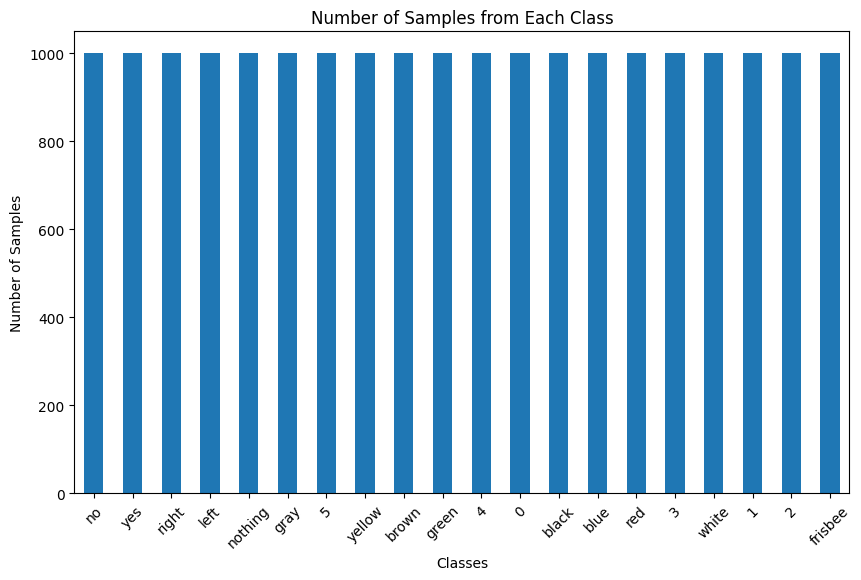

Number of Classes: 20
Classes:
['no' 'yes' '2' '1' 'white' '3' 'red' 'blue' 'black' '0' '4' 'green'
 'brown' 'yellow' '5' 'gray' 'nothing' 'left' 'right' 'frisbee']


In [108]:
# TODO 2: make a report from dataset
# plot
# number of classes and which classes
# number of samples from each class

def make_report(df):
    # Plot number of samples from each class
    plt.figure(figsize=(10, 6))
    df['answer'].value_counts().plot(kind='bar')
    plt.title('Number of Samples from Each Class')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.show()

    # Number of classes and which classes
    num_classes = len(df['answer'].unique())
    classes = df['answer'].unique()

    print(f"Number of Classes: {num_classes}")
    print("Classes:")
    print(classes)

make_report(new_df)

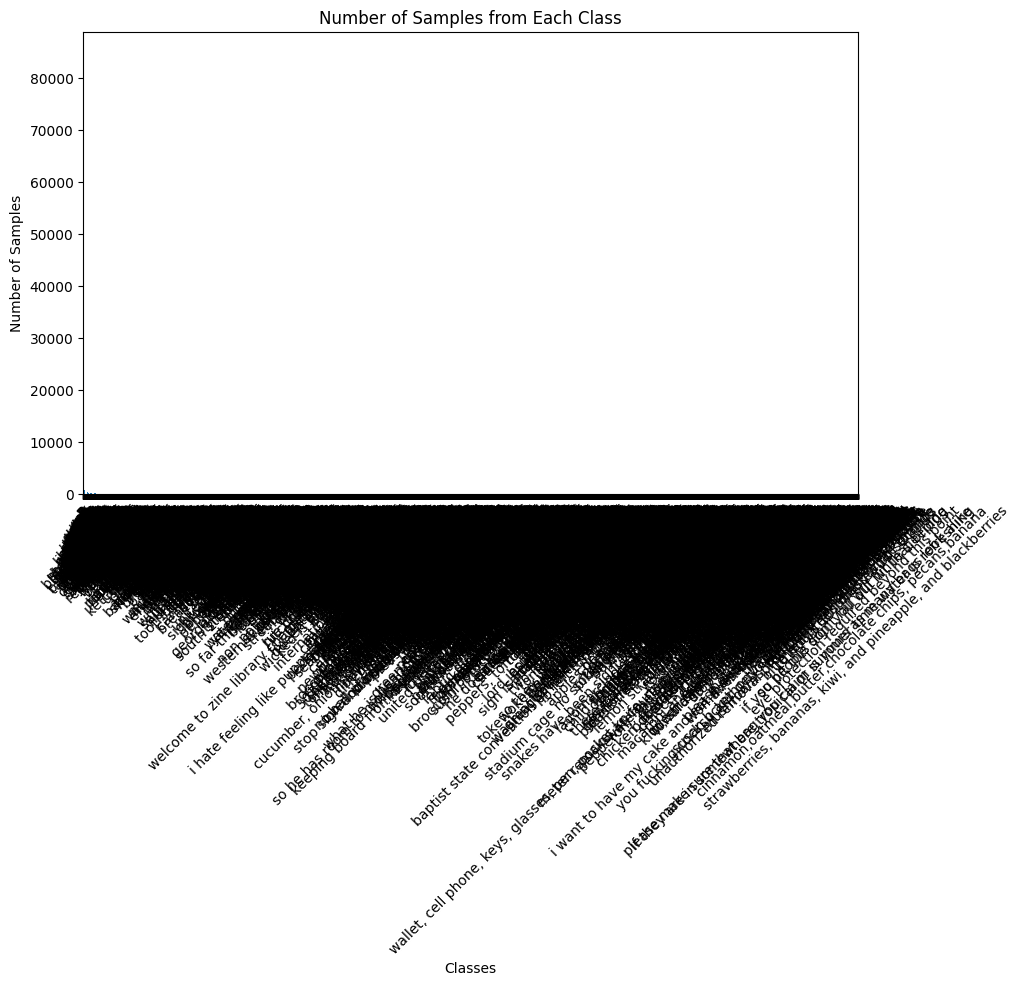

Number of Classes: 22706
Classes:
['net' 'pitcher' 'orange' ... 'scales' 'medium heaviness'
 'sharpening knife']


In [109]:
make_report(df)

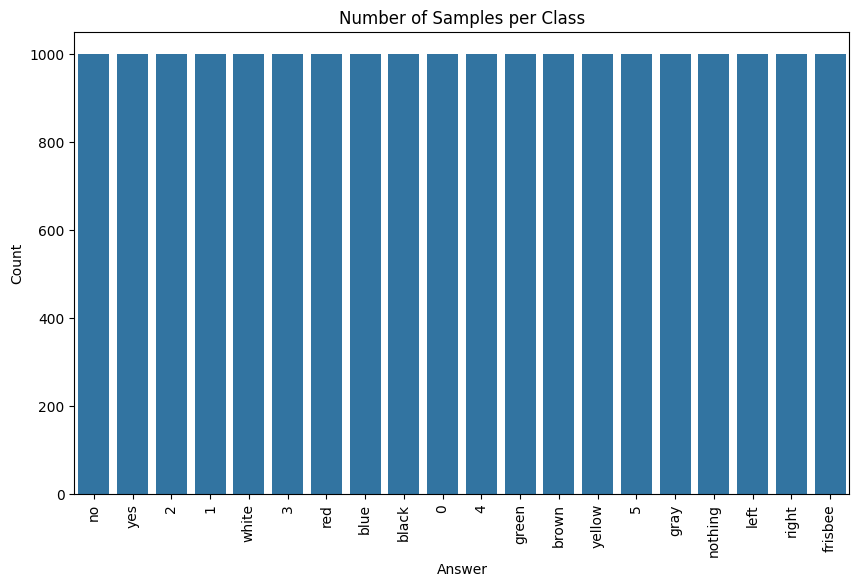

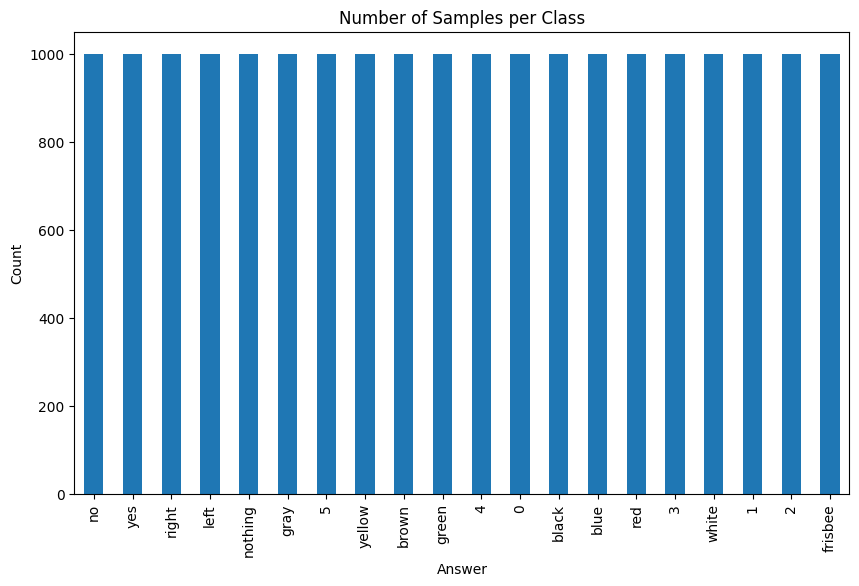

Number of classes: 20
Classes:
['no' 'yes' '2' '1' 'white' '3' 'red' 'blue' 'black' '0' '4' 'green'
 'brown' 'yellow' '5' 'gray' 'nothing' 'left' 'right' 'frisbee']


In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the number of classes and which classes
plt.figure(figsize=(10, 6))
sns.countplot(x='answer', data=new_df)
plt.xticks(rotation=90)
plt.title('Number of Samples per Class')
plt.xlabel('Answer')
plt.ylabel('Count')
plt.show()

# Plot the number of samples from each class
class_counts = new_df['answer'].value_counts()
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Number of Samples per Class')
plt.xlabel('Answer')
plt.ylabel('Count')
plt.show()

# Print the number of classes and the classes
print(f"Number of classes: {len(new_df['answer'].unique())}")
print("Classes:")
print(new_df['answer'].unique())

In [15]:
def train_val_test_split(df, train_portion = 0.9, val_portion = 0.05, test_portion = 0.05):
    df_train, df_val, df_test, _ = np.split(df.sample(frac=1, random_state=42), \
                  [int(train_portion * len(df)), int((train_portion + val_portion) * len(df)), \
                   int((train_portion + val_portion + test_portion) * len(df))])
    # TODO 3: Reset train, val , test dataframe index
    df_train.reset_index(drop=True, inplace=True)
    df_val.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)

    return df_train, df_val, df_test


In [16]:
df_train, df_val, df_test = train_val_test_split(new_df)
max_question_len = max(new_df['question'].apply(lambda x: len(x)))
print(f"max_question_len in new_df['question'] is {max_question_len}")
MAX_LEN = 100

max_question_len in new_df['question'] is 95


In [114]:
max_question_len

95

In [115]:
len(new_df), len(df_train), len(df_val), len(df_test)

(20000, 18000, 1000, 1000)

In [118]:
df_train.head()

,image_id,question,answer
0,309364,How many people are on the beach?,4
1,330917,How many window panes do you see?,2
2,39100,What color is the man's hat?,black
3,292421,Can the most prominent plane fit more than two...,yes
4,132773,What color are the trucks in the foreground?,yellow


In [119]:
df_val.head()

,image_id,question,answer
0,126024,How many heads can be seen?,1
1,532132,How many cups are on top of the display case?,4
2,236897,What color is the accent tile in this kitchen?,red
3,453050,How many humans are in the picture?,0
4,133114,Are there any balconies?,yes


In [120]:
df_test

,image_id,question,answer
0,139355,What color is the bear?,white
1,389855,What color is her shirt?,yellow
2,138604,What color is the carpet?,brown
3,299679,What number is repeated twice on the red sign?,3
4,266563,Does he have a beard?,yes
...,...,...,...
995,318965,What color is the sea?,green
996,144088,What color is the cat's eyes?,green
997,443390,How many zebra heads can you see?,3
998,268900,Is he eating a donut?,no


In [17]:
def get_tokenizer_output(tokenizer, text, attr):
    return np.array(tokenizer(text, padding='max_length', max_length = MAX_LEN, truncation=True, return_tensors="pt")[attr])

In [18]:
train_transform = transforms.Compose([
            transforms.Resize((112,112)),
            transforms.ToTensor(),
        ])

val_transform = transforms.Compose([
            transforms.Resize((112,112)),
            transforms.ToTensor(),
        ])

test_transform = transforms.Compose([
            transforms.Resize((112,112)),
            transforms.ToTensor(),
        ])

class SimpleVQADataset(Dataset):
    def __init__(self, df, tokenizer, classes, transform):
        super(SimpleVQADataset, self).__init__()
        self.df = df
        self.tokenizer = tokenizer
        self.labels = []
        self.label2idx = {c:i for i, c in enumerate(classes)}
        self.idx2label = {i:c for i, c in enumerate(classes)}
        self.mapping = self.cunstruct_mapping_dict()
        self.encodings = {}
        self.encodings['input_ids']=[]
        self.encodings['attention_mask']=[]
        self.transform = transform

        for index, row in df.iterrows():
            self.encodings['input_ids'].append(get_tokenizer_output(self.tokenizer, row['question'], 'input_ids'))
            self.encodings['attention_mask'].append(get_tokenizer_output(self.tokenizer, row['question'], 'attention_mask'))
            self.labels.append(self.label2idx[self.mapping[row['answer'].lower()]])
        self.encodings['input_ids'] = np.array(self.encodings['input_ids'])
        self.encodings['attention_mask'] = np.array(self.encodings['attention_mask'])

        self.img_ids = df['image_id'] # 'image_id' column in dataframe
        self.labels = np.array(self.labels).reshape(-1, 1)


    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} # self.encodings = {'input_ids':[...], 'attention_mask':[...]}
        item['labels'] = torch.tensor(self.labels[idx])
        image_id = self.img_ids[idx]
        item['image_id'] = image_id
        filename = 'COCO_train2014_'+ str(image_id).zfill(12) + '.jpg'
        trg = os.path.join('./images', filename)
        img = self.transform(Image.open(trg).convert('RGB'))
        item['image'] = img

        # item = {'input_ids':[...], 'attention_mask':[...], 'image':[], 'image_id':[], 'labels':[]}
        return item

    def cunstruct_mapping_dict(self, ): 
        map_dict = {}
        for item in self.idx2label.values():
            map_dict[item.lower()] = item
        return map_dict



In [19]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [20]:
classes = new_df['answer'].unique()
classes

array(['no', 'yes', '2', '1', 'white', '3', 'red', 'blue', 'black', '0',
       '4', 'green', 'brown', 'yellow', '5', 'gray', 'nothing', 'left',
       'right', 'frisbee'], dtype=object)

In [21]:
train_dataset = SimpleVQADataset(df_train, tokenizer, classes, train_transform)
val_dataset = SimpleVQADataset(df_val, tokenizer, classes, val_transform)
test_dataset = SimpleVQADataset(df_test, tokenizer, classes, test_transform)

print("ٔNumber of samples in train split", len(train_dataset))
print("Number of samples in val split", len(val_dataset))
print("Number of samples in test split", len(test_dataset))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


ٔNumber of samples in train split 18000
Number of samples in val split 1000
Number of samples in test split 1000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [22]:
import os
import urllib.request
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import matplotlib.pyplot as plt

target_folder = './'
subfolder_name = 'images'
subfolder_path = os.path.join(target_folder, subfolder_name)

if not os.path.exists(subfolder_path):
    os.makedirs(subfolder_path)

unique_image_ids = new_df['image_id'].unique() # just download the sampled datset

def download_image(img_id):
    filename = 'COCO_train2014_'+ str(img_id).zfill(12) + '.jpg'
    src = os.path.join('https://vqa_mscoco_images.s3.amazonaws.com/train2014/', filename)
    trg = os.path.join(subfolder_path, filename)
    if not os.path.exists(trg):
        urllib.request.urlretrieve(src, trg)

# Using ThreadPoolExecutor to concurrently download images
with ThreadPoolExecutor() as executor:
    list(tqdm(executor.map(download_image, unique_image_ids), total=len(unique_image_ids)))


100%|██████████| 14562/14562 [10:18<00:00, 23.53it/s]


# VQA Model

In [23]:
# Step 3: Define the VQA model
class VQAModel(nn.Module):
    def __init__(self, image_feature_extractor, question_feature_extractor, hidden_dim, num_classes):
        super(VQAModel, self).__init__()
        # Image feature extractor (e.g., ResNet50) # CNN
        self.image_feature_extractor = image_feature_extractor

        # Question feature extractor (e.g., LSTM) # RNN
        self.question_feature_extractor = question_feature_extractor

        # Combined image and question classifier # MLP
        self.classifier = nn.Sequential(
            # Define the layers that combine image and question features
            # TODO 5: Linear(hidden_dim, hidden_dim), Dropout 0.2, ReLU, Linear
            nn.Linear(hidden_dim, hidden_dim), # hidden_dim = 512 + 768 = image_dim + question_dim
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, image, input_ids, attention_mask):
        # Process the image through the image_features
        image_embedding = self.image_feature_extractor(image).squeeze((2, 3)) # size: 512

        # Process the question through the question_features
        question_embedding = self.question_feature_extractor(input_ids=input_ids,attention_mask=attention_mask).last_hidden_state.mean(dim=1) # size: 768

        # Combine the image and question features
        # TODO 6: concatenate image embedding and question embedding
        combined_embedding = torch.cat((image_embedding, question_embedding), dim=1) # dim=1 because dim=0 is for batch

        # Make a prediction using the classifier
        output = self.classifier(combined_embedding)
        return output

In [24]:
# Step 4: Train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        total_correct = 0
        total_samples = 0
        for train_batch in tqdm(train_loader):
            images = train_batch['image'].squeeze(1).to(device)
            input_ids = train_batch['input_ids'].squeeze(1).to(device)
            attention_mask = train_batch['attention_mask'].squeeze(1).to(device)
            train_label = train_batch['labels'].squeeze(1).to(device)

            # Forward pass
            outputs = model(images, input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1) # maximum in last layer that contains answers
            # why not argmax?

            # Compute the loss
            loss = criterion(outputs, train_label)

            # Backpropagation
            loss.backward() # compute gradiants
            optimizer.step() # step gradiant decent
            total_loss += loss.item()
            total_correct += (preds == train_label).sum().item()
            total_samples += train_label.size(0)

            # Clear the gradients
            optimizer.zero_grad()

        # Print the loss for this epoch
        print(f"Train, Epoch {epoch + 1} : Loss = {total_loss / len(train_dataloader):.4f}, Accuracy = {total_correct / total_samples:.4f}")

# Step 5: Evaluate the model
def evaluate_model(model, val_loader, criterion, optimizer):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for val_batch in tqdm(val_loader):
            images = val_batch['image'].squeeze(1).to(device)
            input_ids = val_batch['input_ids'].squeeze(1).to(device)
            attention_mask = val_batch['attention_mask'].squeeze(1).to(device)
            val_label = val_batch['labels'].squeeze(1).to(device)

            # Forward pass
            outputs = model(images, input_ids, attention_mask)

            # Get the predicted answers
            _, preds = torch.max(outputs, dim=1)

            # Update total and correct predictions
            total_correct += (preds == val_label).sum().item()
            total_samples += val_label.size(0)

    print(f"Evaluation : Accuracy = {total_correct / total_samples:.4f}")

In [25]:
classes

array(['no', 'yes', '2', '1', 'white', '3', 'red', 'blue', 'black', '0',
       '4', 'green', 'brown', 'yellow', '5', 'gray', 'nothing', 'left',
       'right', 'frisbee'], dtype=object)

In [26]:
if __name__ == "__main__":
    # Set device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    hidden_dim = 512 + 768    # Replace with the desired hidden dimension

    # TODO 7: load resnet18 pretrained
    model_ft = models.resnet18(pretrained=True)

    # TODO 8: use all layers except the last one which is for classification (head layer)
    image_feature_extractor = nn.Sequential(*list(model_ft.children())[:-1])


    question_feature_extractor = DistilBertModel.from_pretrained('distilbert-base-uncased')
    num_classes = len(x)

    model = VQAModel(image_feature_extractor, question_feature_extractor, hidden_dim, num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 10

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0
        for train_batch in tqdm(train_dataloader):
            # train_batch is a list of get_item()
            images = train_batch['image'].squeeze(1).to(device)
            input_ids = train_batch['input_ids'].squeeze(1).to(device).to(device)
            attention_mask = train_batch['attention_mask'].squeeze(1).to(device)
            train_label = train_batch['labels'].squeeze(1).to(device)

            # Forward pass
            outputs = model(images, input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            # >>> torch.max(a, 1)
            #     torch.return_types.max(values=tensor([0.8475, 1.1949, 1.5717, 1.0036]),
            #     indices=tensor([3, 0, 0, 1]))

            # Compute the loss
            loss = criterion(outputs, train_label)

            # Backpropagation
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_correct += (preds == train_label).sum().item()
            total_samples += train_label.size(0)

            # Clear the gradients
            optimizer.zero_grad()
        print(f"Train, Epoch {epoch + 1} : Loss = {total_loss / len(train_dataloader):.4f}, Accuracy = {total_correct / total_samples:.4f}")


        model.eval()
        correct = 0
        total = 0
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        # with torch.no_grad():
        for val_batch in tqdm(val_dataloader):
            images = val_batch['image'].squeeze(1).to(device)
            input_ids = val_batch['input_ids'].squeeze(1).to(device).to(device)
            attention_mask = val_batch['attention_mask'].squeeze(1).to(device)
            val_label = val_batch['labels'].squeeze(1).to(device)

            # Forward pass
            outputs = model(images, input_ids, attention_mask)

            # Get the predicted answers
            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, val_label)

            # Update total and correct predictions
            total_loss += loss.item()
            total_correct += (preds == val_label).sum().item()
            total_samples += val_label.size(0)

        print(f"Evaluation, Epoch {epoch + 1} : Loss = {total_loss / len(val_dataloader):.4f}, Accuracy = {total_correct / total_samples:.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 92.9MB/s]


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

100%|██████████| 282/282 [02:58<00:00,  1.58it/s]


Train, Epoch 1 : Loss = 2.9383, Accuracy = 0.1112


100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


Evaluation, Epoch 1 : Loss = 2.9120, Accuracy = 0.1240


100%|██████████| 282/282 [02:55<00:00,  1.61it/s]


Train, Epoch 2 : Loss = 2.8667, Accuracy = 0.1368


100%|██████████| 16/16 [00:10<00:00,  1.60it/s]


Evaluation, Epoch 2 : Loss = 2.8594, Accuracy = 0.1500


100%|██████████| 282/282 [02:57<00:00,  1.59it/s]


Train, Epoch 3 : Loss = 2.8096, Accuracy = 0.1559


100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


Evaluation, Epoch 3 : Loss = 2.8089, Accuracy = 0.1520


100%|██████████| 282/282 [02:59<00:00,  1.57it/s]


Train, Epoch 4 : Loss = 2.7589, Accuracy = 0.1758


100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


Evaluation, Epoch 4 : Loss = 2.7848, Accuracy = 0.1540


100%|██████████| 282/282 [03:00<00:00,  1.57it/s]


Train, Epoch 5 : Loss = 2.6857, Accuracy = 0.1963


100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


Evaluation, Epoch 5 : Loss = 2.7891, Accuracy = 0.1790


100%|██████████| 282/282 [03:01<00:00,  1.55it/s]


Train, Epoch 6 : Loss = 2.5817, Accuracy = 0.2309


100%|██████████| 16/16 [00:05<00:00,  2.75it/s]


Evaluation, Epoch 6 : Loss = 2.8614, Accuracy = 0.1610


100%|██████████| 282/282 [03:02<00:00,  1.54it/s]


Train, Epoch 7 : Loss = 2.4263, Accuracy = 0.2774


100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Evaluation, Epoch 7 : Loss = 2.7296, Accuracy = 0.2070


100%|██████████| 282/282 [03:05<00:00,  1.52it/s]


Train, Epoch 8 : Loss = 2.2258, Accuracy = 0.3312


100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


Evaluation, Epoch 8 : Loss = 2.8641, Accuracy = 0.2080


100%|██████████| 282/282 [03:02<00:00,  1.54it/s]


Train, Epoch 9 : Loss = 2.0016, Accuracy = 0.3994


100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


Evaluation, Epoch 9 : Loss = 2.9541, Accuracy = 0.2140


100%|██████████| 282/282 [03:01<00:00,  1.56it/s]


Train, Epoch 10 : Loss = 1.7779, Accuracy = 0.4638


100%|██████████| 16/16 [00:10<00:00,  1.47it/s]

Evaluation, Epoch 10 : Loss = 2.8679, Accuracy = 0.2510


In [27]:
evaluate_model(model, test_dataloader, criterion, optimizer)

100%|██████████| 1000/1000 [00:25<00:00, 39.99it/s]

Evaluation : Accuracy = 0.2540
